# 泰坦尼克号生存者预测

## 目录
1. [泰坦尼克号乘客数据](#1)<br> 
2. [数据探索性分析](#2)<br> 
3. [数据处理](#3)<br> 
4. [训练模型](#4)<br> 
5. [模型提升](#5)<br> 


## 1. 泰坦尼克号乘客数据
<a id=1></a>

本案例来源于Kaggle网站上的一个竞赛项目，通过一些乘客的数据来预测哪些乘客会从泰坦尼克号灾难事件中幸存下来。下面是数据集的特征：

| 特征 | 含义 |
|--|--|
|Survival|	是否为生存者|	
|Pclass	|客舱的等级|	
|Sex|	性别|	
|Age|	年龄|	
|Sibsp|	同船的兄弟姐妹或配偶的人数|	
|Parch|	同船的父母或子女的人数|	
|Ticket|	票号|	
|Fare|	票价|	
|Cabin|	客舱号	|
|Embarked|	出发港|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#使用随机森林训练
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


初步观察，存在缺失值的特征有`Age`，`Fare`，`Cabin`，`Embarked`，而且名义特征以及离散的数值特征较多，适合使用决策树类型的模型。

In [5]:
train.Survived.mean()

0.3838383838383838

训练数据集中泰坦尼克号乘客的幸存率约为38%，下面以这个标准，分析对生存率有影响的特征，以便后期数据的处理与模型的训练。


## 2. 数据探索性分析
<a id=2></a>

### 性别

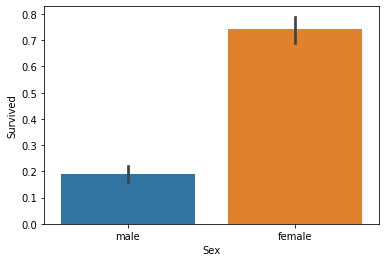

In [6]:
sns.barplot(x="Sex", y="Survived", data=train)

乘客的性别是很大的影响因素，女性乘客生存率会高一些。

### 客舱等级

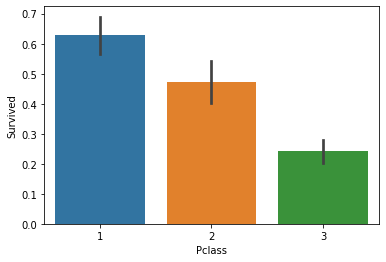

In [7]:
sns.barplot(x="Pclass", y="Survived", data=train)

1等客舱在最上层甲板上，更容易及早获取到危险信号，逃生也方便许多，生存率自然高一些。

### 年龄

Text(12.359751157407416, 0.5, 'density')

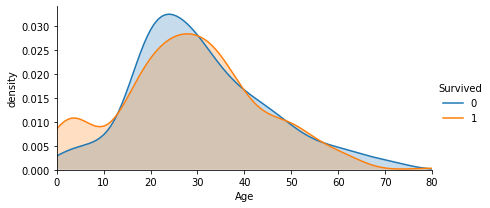

In [8]:
facet1 = sns.FacetGrid(train, hue="Survived",aspect=2)
facet1.map(sns.kdeplot,'Age',shade= True)
facet1.set(xlim=(0, train['Age'].max()))
facet1.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 

可以看出年龄小的乘客生存率更大一些，因为当时船长下令，让妇女和儿童优先登上救生艇撤离。

`Age`特征有很多缺失值，下面考虑通过合适的特征来填补缺失值。

In [9]:
train.drop('PassengerId',axis=1).corr().Age

Survived   -0.077221
Pclass     -0.369226
Age         1.000000
SibSp      -0.308247
Parch      -0.189119
Fare        0.096067
Name: Age, dtype: float64

由于很多特征只有很少几个离散的取值，所以很容易不满足线性关系，因此`Pclass`，`SibSp`，`Parch`是比较相关的特征了，通过经验分析和数据可视化也可以看出，通常仓位等级为1的乘客比较有金钱和地位，年龄偏大，而等级为3的乘客则正好相反；兄弟姐妹比较多的乘客年龄偏小，没有父母和子女的乘客几乎肯定是儿童，而`Parch`大于2的的乘客基本上确定为成年人等等。下面通过随机森林预测年龄：

Text(11.594234664351859, 0.5, 'density')

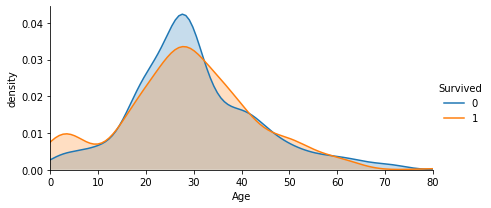

In [4]:
df= train.copy()
age_data = df[['Age', 'Pclass','SibSp','Parch']]#选取Pclass SibSp和Parch特征
#将用未缺失的值进行训练，来预测缺失的值
known_age = age_data[age_data.Age.notnull()].values
missing_age = age_data[age_data.Age.isnull()].values
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100)
rfr.fit(X, y)
pred = rfr.predict(missing_age[:, 1:])
df.loc[(df.Age.isnull()), 'Age' ] = pred
#再画出填充缺失值后的年龄分布图
facet2 = sns.FacetGrid(df, hue="Survived",aspect=2)
facet2.map(sns.kdeplot,'Age',shade= True)
facet2.set(xlim=(0, df['Age'].max()))
facet2.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 

这个结果相对来说开始可以接受的，并没有过于改变生存下来的乘客与未生存下来的乘客的年龄的相对分布，尤其交点处基本没变。

### 票价

Text(11.594234664351859, 0.5, 'density')

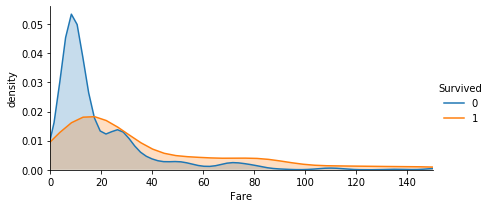

In [11]:
facet3 = sns.FacetGrid(train, hue="Survived",aspect=2)
facet3.map(sns.kdeplot,'Fare',shade= True)
facet3.set(xlim=(0, 150))
facet3.add_legend()
plt.xlabel('Fare') 
plt.ylabel('density')

金钱的力量还是很现实的。

关于`Fare`缺失值：

In [12]:
test.loc[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


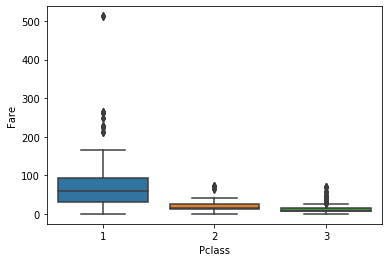

In [13]:
sns.boxplot(x='Pclass', y='Fare', data=train)

可以使用第3船舱的票价的均值来填补。

### 家人

乘客的家人包括他的兄弟姐妹配偶，还有他的父母子女。通常来说，有家人的帮助会更容易生存下来。

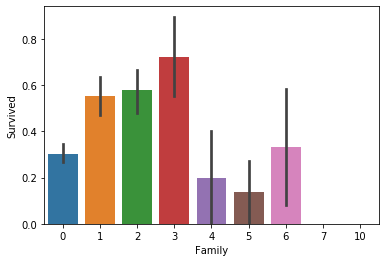

In [14]:
train['Family']=train['SibSp']+train['Parch']
sns.barplot(x="Family", y="Survived", data=train)

可以看出，只有自己一个人在船上的乘客的生存率基本上和总生存率差不多，而有1到3个家人的乘客生存率会高一些，有4到6个家人的乘客数量可能比较少，所以他们的生存率波动较大，而且有这么多家人的乘客一般都住在最底层的船舱，有可能全家都没能幸免。通过分析，因此可以尝试将这个特征分成4组。

### 出发港

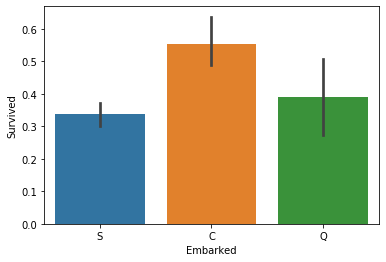

In [15]:
sns.barplot(x='Embarked',y='Survived', data=train)

从C港出发的乘客生存率会大一些，这很可能是因为C港出发的人比较有钱。

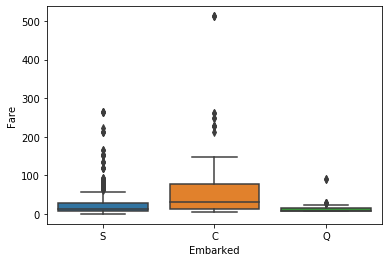

In [16]:
sns.boxplot(x='Embarked', y='Fare', data=train)

In [17]:
train.loc[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


所以可以推测，这两个乘客很可能是从C港出发的。

### 客舱号

这个特征由于有大量的缺失值，可能对分类并没有特别大的影响，但是也可以提取出一些有用信息。比如讲客舱号的首字母提取出来，这可能比`Pclass`更加详细地代表了船的某一部分区域。

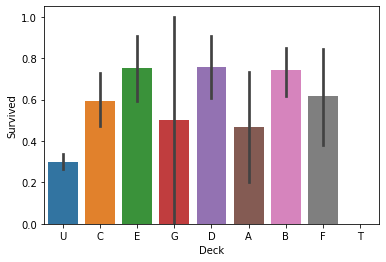

In [18]:
train['Cabin'] = train['Cabin'].fillna('Unknown')
train['Deck']=train['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=train)

可见B类，D类，C类和E类船舱的乘客生存率比较大一些，而U类，即缺失船舱号的乘客比较接近总体的生存率，其他类船舱的乘客生存率波动较大，无法准确判断，因此可以将船舱号划分为3类。

### 名字
名字中也包含了乘客的很多信息，比如性别，身份，地位等，应该尝试提取出这部分信息。

In [6]:
train['Status'] = train['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
train["Status"].value_counts().head(5)

Mr        517
Miss      182
Mrs       125
Master     40
Dr          7
Name: Status, dtype: int64

可以根据经验，将这些称呼分成6类。

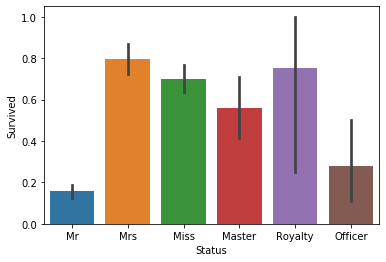

In [7]:
train['Status'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
train['Status'].replace(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty', inplace=True)
train['Status'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs', inplace=True)
train['Status'].replace(['Mlle', 'Miss'], 'Miss', inplace=True)
train['Status'].replace('Jonkheer', 'Master', inplace=True)

sns.barplot(x="Status", y="Survived", data=train)

## 3. 数据处理
<a id=3></a>

下面通过上一节的分析，总结出相应的数据处理：
- `PassengerId`，`Ticket`属于无关信息，做删除处理。
- 特征提取：
    - 从`Name`中提取出身份信息
    - 将`SibSp` 和 `Parch`合并成新的特征
    - 从`Cabin`中提取出新的特征
- 补充缺失值：
    - 使用使用随机森林结合其它相关特征进行预测`Age`
    - `Fare` 和 `Embarked`根据上节分析直接补充缺失值
- 对数据做编码处理


### 整合数据

In [21]:
PassengerId=test['PassengerId']#由于后期还需要使用ID得到结果，所以先保存起来
all_data = pd.concat([train, test], ignore_index = True)#将测试数据和训练数据整合在一块，方便统一处理
all_data.set_index('PassengerId', inplace=True)
all_data.drop('Ticket', axis=1 ,inplace=True)

### 特征提取

从`Name`中提取乘客身份信息。

In [22]:
all_data['Status'] = all_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
all_data['Status'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
all_data['Status'].replace(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty', inplace=True)
all_data['Status'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs', inplace=True)
all_data['Status'].replace(['Mlle', 'Miss'], 'Miss', inplace=True)
all_data['Status'].replace('Jonkheer', 'Master', inplace=True)

从`SibSp` 和 `Parch`提取家人信息并分类。

In [23]:
all_data['Family']=all_data['SibSp']+all_data['Parch']
def Fam_label(s):
    if (s == 0):
        return 0
    elif (s >= 1) & (s <= 3):
        return 1
    elif ((s >= 4) & (s <= 6)):
        return 2
    elif (s >= 7):
        return 3
all_data['FamilyLabel']=all_data['Family'].apply(Fam_label)

从`Cabin`中提取船舱号信息并分类。

In [24]:
all_data['Cabin'].fillna('Unknown',inplace=True)
all_data['Deck']=all_data['Cabin'].str.get(0)
def Cabin_label(s):
    if ((s == 'B') & (s == 'C') & (s == 'D') & (s == 'E')):
        return 2
    elif (s == 'U'):
        return 1
    else :
        return 0
all_data['CabinLable']=all_data['Deck'].apply(Cabin_label)

### 补充缺失值

使用随机森林算法预测缺失的年龄数据：

In [25]:
from sklearn.ensemble import RandomForestRegressor
age = all_data[['Age', 'Pclass','SibSp','Parch']]
known_age = age[age.Age.notnull()].values
unknown_age = age[age.Age.isnull()].values
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100)
rfr.fit(X, y)
pred_Ages = rfr.predict(unknown_age[:, 1::])
all_data.loc[(all_data.Age.isnull()), 'Age' ] = pred_Ages 

补充出发港，船票的缺失值：

In [26]:
all_data['Embarked'].fillna('C',inplace=True)
all_data['Fare'].fillna(all_data.loc[all_data.Pclass ==3].Fare.median(), inplace = True)

In [27]:
all_data.isnull().any()

Survived        True
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
Family         False
Deck           False
Status         False
FamilyLabel    False
CabinLable     False
dtype: bool

除了目标特征`Survived`，其余特征已经没有缺失值了。

### 数据整理

选取训练时需要用到的特征,并做编码处理，由于是使用树模型，并不需要进行OneHot编码：

In [28]:
select_data  = all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Status','FamilyLabel','CabinLable']]
select_data.loc[:,['Sex','Embarked','Status']] = select_data[['Sex','Embarked','Status']].apply(LabelEncoder().fit_transform).values

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


然后把需要上传到Kaggle上的测试集和已知标签的训练集分开。

In [29]:
train_data=select_data[select_data['Survived'].notnull()]
test_data=select_data[select_data['Survived'].isnull()].drop('Survived',axis=1)
X = train_data.iloc[:,1:]
y = train_data.iloc[:,0]

使用已知标签的训练集`X`，`y`来训练模型。

## 4. 训练模型
<a id=4></a>

使用随机森林模型，以及通过交叉验证和评价指标F1-Score进行适当地调参：

In [30]:
clf = RandomForestClassifier(random_state = 10, 
                                  n_estimators = 500,
                                  max_depth = 6)
cv_score = cross_val_score(clf, X, y, cv= 10, scoring='f1')
cv_score

array([0.75      , 0.83076923, 0.61016949, 0.87323944, 0.86153846,
       0.72131148, 0.74576271, 0.64285714, 0.81818182, 0.74626866])

In [31]:
cv_score.mean(),cv_score.std()

(0.7600098425482457, 0.08347833164692214)

观察一下特征的重要程度排名：

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

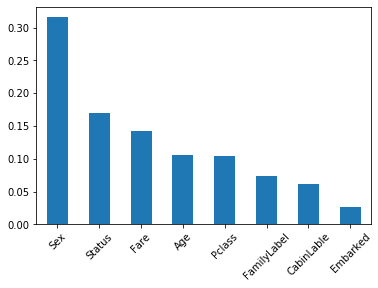

In [32]:
clf.fit(X,y)
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)

从图中看出`Family`和`Cabin`的特征重要程度比较小，可是按照经验来看，同一船舱的乘客由于可以互相提醒，互相帮助，很有可能会大家一起逃生，或一起遇难，在同一家庭的乘客住的比较近，也会有这样的规律。但是目前的特征不能很好的利用这样规律，因此，如果要想提高预测准确性，还需要挖掘新的特征。

In [33]:
predictions = clf.predict(test_data)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv('submission_1.csv', index=False)

<img src="Kaggle成绩排名1.png" width="80%">

如果只利用这些特征，最后在Kaggle上可以达到0.79左右的得分。

## 5. 模型提升
<a id=5></a>


由上节的分析，同一家族的乘客很可能同时逃生或同时丧生，希望可以将同一家族的乘客分组到一起来分析，自然想到从`Name`中挖掘出更好的特征，即使用姓氏来分组:

In [34]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])

由于船长的命令，使得儿童和女性乘客更有可能生存下来。但是，由于一些情况，有些家庭并没有及时获得相关的消息，因此会有同一个家庭内的儿童或女性乘客一起遇难。同样的，成年男性乘客的生存率很低，但也有些也在家人的帮助下生存下来，我们需要找到特征可以反映出这方面的信息。

分别将有其他家庭成员的儿童或女性乘客，以及成年男性乘客提取出来：

In [35]:
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

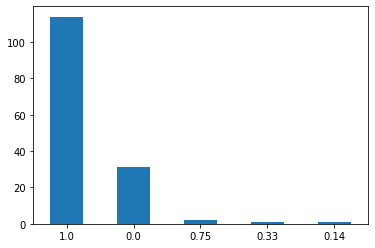

In [36]:
Female_Child_Group.groupby('Surname')['Survived'].mean().apply(lambda x: round(x,2)).value_counts().plot.bar()
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

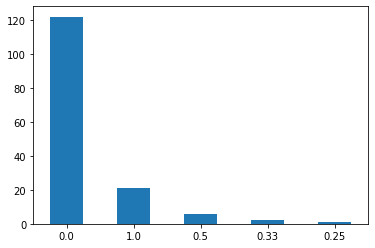

In [37]:
Male_Adult_Group.groupby('Surname')['Survived'].mean().apply(lambda x: round(x,2)).value_counts().plot.bar()
plt.xticks(rotation=0)

从上面两图可以看出大致符合我们的推理，这两个组的每个家庭几乎要么都幸存要么都遇难，由于只基于上节的特征，会把儿童或女性乘客组大概率预测生存，把成年男性组大概率预测为遇难，因此我们想添加两个特征，希望模型可以区分出儿童或女性乘客组中的遇难成员，以及成年男性组中的幸存者：

In [38]:
Female_Child_List=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_List[Female_Child_List.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Lefebre', 'Rosblom', 'Cacic', 'Boulos', 'Canavan', 'Oreskovic', 'Robins', 'Sage', 'Attalah', 'Strom', 'Zabour', 'Lahtinen', 'Van Impe', 'Bourke', 'Barbara', 'Lobb', 'Panula', 'Goodwin', 'Rice', 'Turpin', 'Palsson', 'Johnston', 'Skoog', 'Danbom', 'Arnold-Franchi', 'Jussila', 'Olsson', 'Caram', 'Ilmakangas', 'Vander Planke', 'Ford'}
{'Jonsson', 'Goldenberg', 'Greenfield', 'Kimball', 'Chambers', 'Frauenthal', 'Bishop', 'Frolicher-Stehli', 'McCoy', 'Beane', 'Daly', 'Taylor', 'Bradley', 'Harder', 'Dick', 'Nakid', 'Jussila', 'Cardeza', 'Beckwith', 'Duff Gordon', 'Moubarek'}


添加特征`Victims`和`Survivors`来标记遇难的乘客和幸存的乘客：

In [39]:
all_data['Victims'] = all_data.Surname.apply(lambda x: int(x in Dead_List))
all_data['Survivors'] = all_data.Surname.apply(lambda x: int(x in Survived_List))

重复上节训练模型操作:

In [40]:
new_data  = all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Status',
                      'FamilyLabel','CabinLable','Victims','Survivors']]
new_data.loc[:,['Sex','Embarked','Status']] = new_data[['Sex','Embarked','Status']].apply(LabelEncoder().fit_transform).values

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [41]:
new_train=new_data[new_data['Survived'].notnull()]
new_test=new_data[new_data['Survived'].isnull()].drop('Survived',axis=1)
new_X = new_train.iloc[:,1:]
new_y = new_train.iloc[:,0]

In [42]:
clf_improved = RandomForestClassifier(random_state = 10, 
                                  n_estimators = 500,
                                  max_depth = 6)
new_cv_score = cross_val_score(clf_improved, new_X, new_y, cv= 10, scoring='f1')
new_cv_score

array([0.82539683, 0.92307692, 0.71186441, 0.90140845, 0.88888889,
       0.8125    , 0.85714286, 0.8       , 0.89230769, 0.84057971])

In [43]:
new_cv_score.mean(),new_cv_score.std()

(0.8453165754442, 0.05899048900112746)

与上节结果比较，可知模型预测性能获得大幅提升。

In [44]:
clf_improved.fit(new_X,new_y)
predictions = clf_improved.predict(new_test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv('submission_2.csv', index=False)

在Kaggle上的得分也获得了一定的提升。

<img src="Kaggle成绩排名2.png" width="80%">